In [1]:
#导入常用包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

In [2]:
# 导入机器学习包
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [3]:
# 路径处理库
import pathlib as pb
from pathlib import Path

In [4]:
class Data_Preprocessing(object):
    # 定义构造方法
    def __init__(self, dynamic_features, dynamic_annotations,target_name,score,dataset_name):  #__init__() 是类的初始化方法；它在类的实例化操作后 会自动调用，不需要手动调用；
        # 设置属性
        self.dynamic_features = dynamic_features
        self.dynamic_annotations = dynamic_annotations
        self.target_name = target_name
        self.score = score
        self.dataset_name=dataset_name
        #  分组求每一首歌的frametime个数
    def dynamic_features_count(self):
        dynamic_features_count=self.dynamic_features.groupby(['musicId']).count()
        #输出为excel
        dynamic_features_frameTime_count=pd.DataFrame(dynamic_features_count.iloc[:,0])
        dynamic_features_frameTime_count.columns=['frameTime']
        return dynamic_features_frameTime_count
    # 数据清洗：输出用于随机森林降维的数据集 ，未划分和划分了目标变量的每首歌记录时间长度长短
    def dataset_merge(self):
        # 数据清洗
        dynamic_features_frameTime_count=self.dynamic_features_count()
        Dynamic=pd.merge(self.dynamic_features, self.dynamic_annotations, how='right',on=['musicId','frameTime'])
        Dynamic_count=Dynamic.groupby("musicId").count()
        Dynamic_frameTime_count=pd.DataFrame(Dynamic_count['frameTime'])
        Dynamic_frameTime_minus=dynamic_features_frameTime_count-Dynamic_frameTime_count
        Dynamic_music_id=pd.DataFrame(Dynamic['musicId'].unique())
        dynamic_features_frameTime_count=dynamic_features_frameTime_count.reset_index()
        dynamic_features_frameTime_count.columns=['musicId','dynamic_features_frameTime_count']
        Dynamic_frameTime_count=Dynamic_frameTime_count.reset_index()
        Dynamic_frameTime_count.columns=['musicId','Dynamic_frameTime_count']
        frameTime_count_all=pd.merge(dynamic_features_frameTime_count, Dynamic_frameTime_count, how='right', left_on=['musicId'], right_on=['musicId'])
        # 提取用于时间序列滞后阶数的数据集
        musicid=pd.DataFrame(frameTime_count_all['musicId'])
        dynamic_features_analyze=pd.merge(self.dynamic_features,musicid, how='inner', left_on=['musicId'], right_on=['musicId'])
        # 创建保存路径名称
        path1=str(path_file)+'/'+self.dataset_name+'/frameTime_count'
        Path(path1).mkdir(parents=True, exist_ok=True)
        #数据输出
        frameTime_count_all.to_excel(path1+'/frameTime_count_all.xlsx')
        Dynamic_frameTime_minus.to_excel(path1+'/Dynamic_frameTime_minus.xlsx')
        return Dynamic,frameTime_count_all,Dynamic_frameTime_minus,dynamic_features_analyze
    # 随机森林降维，输出图像
    def train_model(self):
        [Dynamic,frameTime_count_all,Dynamic_frameTime_minus,dynamic_features_analyze]=self.dataset_merge()
        # 数据预分割
        Dynamic.Data=Dynamic.iloc[:,1:-2]
        Dynamic.Target=pd.DataFrame(Dynamic[self.target_name])
        # 创建保存路径名称
        path2=str(path_file)+'/'+self.dataset_name+'/randomforest/'+self.target_name
        Path(path2).mkdir(parents=True, exist_ok=True)
        # 训练集与验证集划分
        train_data,test_data,train_target,test_target=train_test_split(Dynamic.Data,Dynamic.Target,test_size=0.2,random_state=0)
        # 模型训练
        clf=RandomForestRegressor(n_estimators=200)#200棵树
        RD=clf.fit(train_data,train_target)
        #采用拟合优度指标评价
        print("测试数据集拟合优度：{:.2f}".format(RD.score(train_data,train_target)))
        print("训练数据集拟合优度：{:.2f}".format(RD.score(test_data,test_target)))
        #采用MSE指标评价
        score1=mean_squared_error(train_target,RD.predict(train_data))
        score2=mean_squared_error(test_target,RD.predict(test_data))
        print("训练数据集MSE得分：{:.2f}".format(score1))
        print("测试数据集MSE得分：{:.2f}".format(score2))
        #采用MAE指标评价
        score1=mean_absolute_error(train_target,RD.predict(train_data))
        score2=mean_absolute_error(test_target,RD.predict(test_data))
        print("训练数据集MAE得分：{:.2f}".format(score1))
        print("测试数据集MAE得分：{:.2f}".format(score2))
        # 画图
        feat_importances = pd.Series(RD.feature_importances_, index=train_data.columns)
        feat_importances.nlargest(20).plot(kind='barh')
        plt.xlabel(self.dataset_name+'-'+self.target_name)
        plt.savefig(path2+'/'+self.dataset_name+'-'+self.target_name+'.png', bbox_inches = 'tight')
        #前20个最重要的影响因素
        most_importance=feat_importances.nlargest(20).index
        #生成重要性表格
        importance = clf.feature_importances_
        #np.argsort()返回待排序集合从小到大的索引值，[::-1]实现倒序，即最终imp_result内保存的是从大到小的索引值
        imp_result = np.argsort(importance)[::-1][:np.size(importance)]
        #将数据从大到小排列,并按行输出
        value=np.sort(importance,axis=0)[::-1]
        #将数据的标签从大到小排列
        feat_labels = train_data.columns
        feat_labels = [feat_labels[i] for i in imp_result]
        imp_result=pd.DataFrame(imp_result)
        feat_labels=pd.DataFrame(feat_labels)
        value=pd.DataFrame(value)
        L=pd.concat([feat_labels,value],axis=1)
        L.columns=('feature','data')
        DATA1=L.loc[L['data']>self.score]
        F=DATA1['feature']
        Arousal_mean=Dynamic[F]
        Arousal_mean[self.target_name]=Dynamic.Target
        feature=pd.DataFrame(Arousal_mean.columns)
        feature=feature.iloc[0:-1]
        feature.columns=(['feature'])
        # 利用降维过的数据重新生成一份
        dynamic_features_analyze=dynamic_features_analyze[feature['feature']]
        dynamic_features_analyze.to_excel(path2+'/dynamic_features_analyze.xlsx')
        #return dynamic_features_analyze

C:\Users\Rain\AppData\Local\Temp\ipykernel_13956\2753444093.py:44: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  Dynamic.Data=Dynamic.iloc[:,1:-2]
C:\Users\Rain\AppData\Local\Temp\ipykernel_13956\2753444093.py:45: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  Dynamic.Target=pd.DataFrame(Dynamic[self.target_name])
C:\Users\Rain\AppData\Local\Temp\ipykernel_13956\2753444093.py:53: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RD=clf.fit(train_data,train_target)


测试数据集拟合优度：0.96
训练数据集拟合优度：0.72
训练数据集MSE得分：0.00
测试数据集MSE得分：0.01
训练数据集MAE得分：0.03
测试数据集MAE得分：0.07


C:\Users\Rain\AppData\Local\Temp\ipykernel_13956\2753444093.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Arousal_mean[self.target_name]=Dynamic.Target


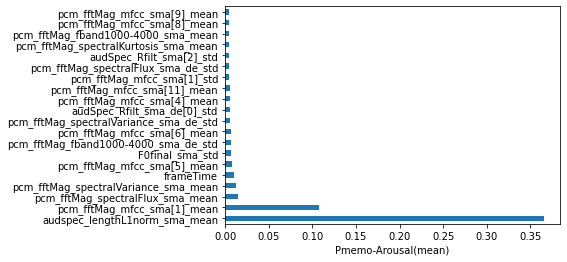

In [5]:
if __name__ == "__main__":
    # 当前文件夹路径
    path_file=Path.cwd()
    # 读取特征数据
    dynamic_features=pd.DataFrame(pd.read_csv(str(path_file)+"/Dataset/Pmemo/dynamic_features.csv"))
    # 读取target的数据
    dynamic_annotations=pd.DataFrame(pd.read_csv(str(path_file)+"/Dataset/Pmemo/dynamic_annotations.csv"))
    score=0.0015
    Data_Preprocessing(dynamic_features,dynamic_annotations,'Arousal(mean)',score,'Pmemo').train_model()
    

C:\Users\Rain\AppData\Local\Temp\ipykernel_13956\2753444093.py:44: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  Dynamic.Data=Dynamic.iloc[:,1:-2]
C:\Users\Rain\AppData\Local\Temp\ipykernel_13956\2753444093.py:45: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  Dynamic.Target=pd.DataFrame(Dynamic[self.target_name])
C:\Users\Rain\AppData\Local\Temp\ipykernel_13956\2753444093.py:53: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RD=clf.fit(train_data,train_target)


测试数据集拟合优度：0.95
训练数据集拟合优度：0.64
训练数据集MSE得分：0.00
测试数据集MSE得分：0.01
训练数据集MAE得分：0.03
测试数据集MAE得分：0.08


C:\Users\Rain\AppData\Local\Temp\ipykernel_13956\2753444093.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Arousal_mean[self.target_name]=Dynamic.Target


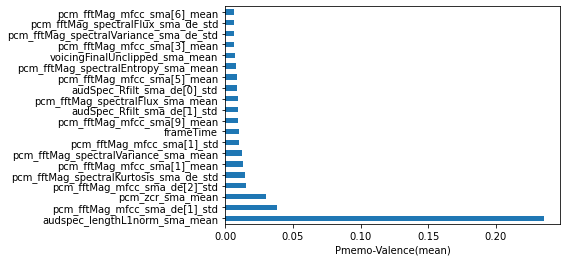

In [6]:
Data_Preprocessing(dynamic_features,dynamic_annotations,'Valence(mean)',score,'Pmemo').train_model()